# Numerical Implementation of a 2D Simplified Wildfire Mathematical Model


<img src=https://www.munichre.com/content/dam/munichre/global/images/royalty-free/GettyImages-145057928.jpg/_jcr_content/renditions/cropped.3_to_1.jpg./cropped.3_to_1.jpg>

**Miembros:**
- Roberto González
- Nicolás Boyardi


Se importan los paquetes necesarios

In [1]:
const USE_GPU = false  # Use GPU? If this is set false, then no GPU needs to be available
using ParallelStencil
using ParallelStencil.FiniteDifferences2D
@static if USE_GPU
    @init_parallel_stencil(CUDA, Float64, 2)
else
    @init_parallel_stencil(Threads, Float64, 2)
end
using Plots, Printf, Statistics

## Parámetros involucrados

A continuación se muestran los parametros físicos involucrados

In [2]:
# parametros del combustible a
εa = 3e-1
qa = 1.0 
upca = 3.0

# parametros del combustible b
εb = 3.5e-1
qb = 1.5
upcb = 3.0

# ratios involucrados
ratio_temp=εb/εa # ratio entre energía de activación
ratio_tiempo=(εb/qb*exp(1/εb))/(εa/qa*exp(1/εa) ) 
ratio_ca= 1/2
ratio_cb= 1/2

# coef. de enfriamiento de Newton(como se enfría verticalmente)
α = 1e-3 

# coef. de difusión
κ= 1e-1 

# tamaño de la simulación en cada dimensión
lx=90
ly=90
lt=20

20

A continuación se incluyen los parámetros de la simulación númerica

In [3]:
# Space nodes(better if multiple of 32)
Nx = 128*4
Ny = 128*4
# Time nodes
Nt = 2000
dx, dy    = lx/(Nx-1), ly/(Ny-1) # cell sizes
dt=lt/Nt

0.01

Por último los parámetros que iran en el cálculo numérico

In [4]:
coef_resulta=dt*0.5* εa/qa
coef_resultb=dt*0.5* εb/qb/ratio_tiempo
coef_energiaa= ratio_ca
coef_energiab= ratio_cb*ratio_temp/ratio_tiempo

1.2074472300149883

## Definición de funciones


Se crea una función para cálcular
$$H^i_{pc}(u) \exp\left(\frac{u}{1 + \varepsilon_i u}\right) $$
con $i\in \{a,b\}$

In [5]:
@parallel function compute_expo!(expo::Data.Array,u::Data.Array, β::Data.Array,ϵ::Data.Number,upc::Data.Number,q::Data.Number)
    @all(expo)=(sign(@all(u)-upc)+1).* @all(β) .* exp(@all(u)/(1+ϵ*@all(u))) 
    return
end

compute_expo! (generic function with 1 method)

Se crea una función para calcular el paso de $\beta$

In [6]:
@parallel function compute_result!(expo::Data.Array, β::Data.Array, coef::Data.Number)
    @all(β)=@all(β)-@all(expo)*coef
    return
end

compute_result! (generic function with 1 method)

Se crea una función para el paso de $u$

In [7]:
@parallel function compute_temperature_2!(u::Data.Array, w1::Data.Array, w2::Data.Array,dx::Data.Number,dy::Data.Number,dt::Data.Number,κ::Data.Number,α::Data.Number,coef_energiaa::Data.Number,coef_energiab::Data.Number,expoa::Data.Array,expob::Data.Array)
    @inn(u)=@inn(u) + dt*(-α*@inn(u) -@inn(w1) .* @d_xi(u)/dx - @inn(w2) .* @d_yi(u)/dy + κ*(@d2_xi(u)/dx/dx+ @d2_yi(u)/dy/dy)+coef_energiaa*@inn(expoa)+coef_energiab*@inn(expob)) 
    return
end

compute_temperature_2! (generic function with 1 method)

## Condiciones iniciales

Se crean los arrays necesarios y se definen condiciones iniciales

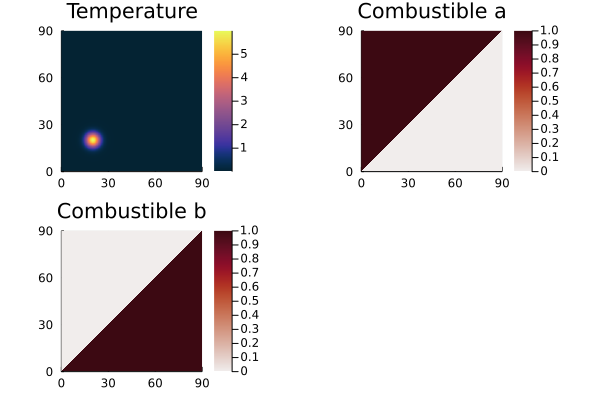

In [8]:
# Array allocations
u=@zeros(Nx,Ny)
βa=@zeros(Nx,Ny)
βb=@zeros(Nx,Ny)

# parametros del viento
θ = π/4
V= 1.0

w1=cos(θ)*@ones(Nx,Ny)
w2=sin(θ)*@ones(Nx,Ny)

# Matrices auxiliares
expoa=@zeros(Nx,Ny)
expob=@zeros(Nx,Ny)

#Initial conditions
u .= 6*Data.Array([exp(-((x-20)^2+(y-20)^2)/20) for x = 0:dx:lx, y= 0:dy:ly ])
βa .= Data.Array([ (x>y)   for x = 0:dx:lx, y= 0:dy:ly])
βb .= Data.Array([ (x<=y)   for x = 0:dx:lx, y= 0:dy:ly])

#Plot initial conditions
x, y = 0:dx:lx, 0:dy:ly
p1 = heatmap(x,y, Array(u), aspect_ratio=1, xlims=(x[1],x[end]), ylims=(y[1],y[end]), c=:thermal, title="Temperature")
p2 = heatmap(x,y, Array(βa), aspect_ratio=1, xlims=(x[1],x[end]), ylims=(y[1],y[end]),  c=:amp, title="Combustible a")
p3 = heatmap(x,y,Array(βb), aspect_ratio=1, xlims=(x[1],x[end]), ylims=(y[1],y[end]),  c=:amp, title="Combustible b")
plot(p1,p2,p3)

## Cálculo y visualización

Animation directory: ./ejemplo1/

Total steps=2000, time=3.555e+01 sec (@ T_eff = 0.71 GB/s) 


┌ Info: Saved animation to 
│   fn = c:\Users\bobaf\Desktop\Incendios forestales\Código\julia\ejemplo1.gif
└ @ Plots C:\Users\bobaf\.julia\packages\Plots\qbc7U\src\animation.jl:114


Plots.AnimatedGif("c:\\Users\\bobaf\\Desktop\\Incendios forestales\\Código\\julia\\ejemplo1.gif")
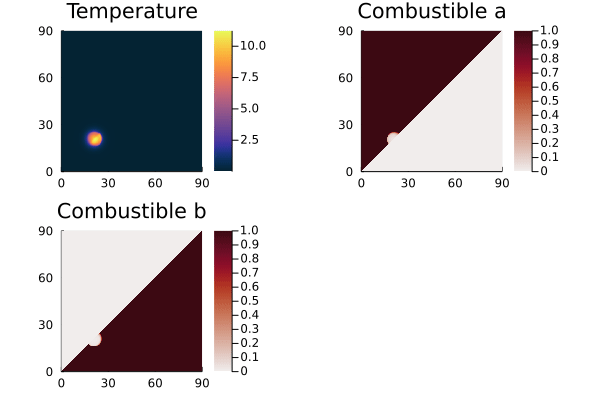

In [10]:
# Preparation of visualisation
ENV["GKSwstype"]="nul"; if isdir("ejemplo1")==false mkdir("ejemplo1") end; loadpath = "./ejemplo1/"; anim = Animation(loadpath,String[])
println("Animation directory: $(anim.dir)")


t=0
nout=100
global wtime0 = Base.time()
for it = 1:Nt
    # Visualisation
    if mod(it,nout)==0
       p1 = heatmap(x,y, Array(u), aspect_ratio=1, xlims=(x[1],x[end]), ylims=(y[1],y[end]), c=:thermal, title="Temperature")
        p2 = heatmap(x,y, Array(βa), aspect_ratio=1, xlims=(x[1],x[end]), ylims=(y[1],y[end]),  c=:amp, title="Combustible a")
        p3 = heatmap(x,y,Array(βb), aspect_ratio=1, xlims=(x[1],x[end]), ylims=(y[1],y[end]),  c=:amp, title="Combustible b")
        plot(p1,p2,p3); frame(anim)
    end

@parallel compute_expo!(expoa,u,βa,εa,upca,qa)  
@parallel compute_result!(expoa, βa,coef_resulta)
@parallel compute_expo!(expob,u,βb,εb,upcb,qb)  
@parallel compute_result!(expob, βb,coef_resultb)
@parallel compute_temperature_2!(u,w1,w2,dx,dy,dt,κ,α,coef_energiaa,coef_energiab,expoa,expob)
end

wtime    = Base.time() - wtime0
append!(tiempo,wtime)
A_eff    = (2*2+2)/1e9*Nx*Ny*sizeof(Data.Number)  # Effective main memory access per iteration [GB] (Lower bound of required memory access: H and dHdτ have to be read and written (dHdτ for damping): 4 whole-array memaccess; B has to be read: 1 whole-array memaccess)
wtime_it = wtime/Nt                          # Execution time per iteration [s]
T_eff    = A_eff/wtime_it                         # Effective memory throughput [GB/s]
@printf("Total steps=%d, time=%1.3e sec (@ T_eff = %1.2f GB/s) \n", Nt, wtime, round(T_eff, sigdigits=2))
gif(anim, "ejemplo1.gif", fps = 24)

In [15]:
rm("ejemplo1",recursive=true)

## Benchmarking

In [11]:
tiempo=[]

Any[]

In [12]:
for i in 1:10
# Array allocations
u=@zeros(Nx,Ny)
βa=@zeros(Nx,Ny)
βb=@zeros(Nx,Ny)

# parametros del viento
θ = π/4
V= 1.0

w1=convert(Float32,cos(θ))*@ones(Nx,Ny)
w2=convert(Float32,sin(θ))*@ones(Nx,Ny)

# Matrices auxiliares
expoa=@zeros(Nx,Ny)
expob=@zeros(Nx,Ny)

#Initial conditions
u .= 6*Data.Array([convert(Float32,exp(-((x-20)^2+(y-20)^2)/20)) for x = 0:dx:lx, y= 0:dy:ly ])
βa .= Data.Array([ (x>y)   for x = 0:dx:lx, y= 0:dy:ly])
βb .= Data.Array([ (x<=y)   for x = 0:dx:lx, y= 0:dy:ly])

#Plot initial conditions
x, y = 0:dx:lx, 0:dy:ly

t=0
nout=100
global wtime0 = Base.time()
for it = 1:Nt
    @parallel compute_expo!(expoa,u,βa,εa,upca,qa)  
    @parallel compute_result!(expoa, βa,coef_resulta)
    @parallel compute_expo!(expob,u,βb,εb,upcb,qb)  
    @parallel compute_result!(expob, βb,coef_resultb)
    @parallel compute_temperature_2!(u,w1,w2,dx,dy,dt,κ,α,coef_energiaa,coef_energiab,expoa,expob)
end

wtime    = Base.time() - wtime0
append!(tiempo,wtime)
A_eff    = (2*2+2)/1e9*Nx*Ny*sizeof(Data.Number)  # Effective main memory access per iteration [GB] (Lower bound of required memory access: H and dHdτ have to be read and written (dHdτ for damping): 4 whole-array memaccess; B has to be read: 1 whole-array memaccess)
wtime_it = wtime/Nt                          # Execution time per iteration [s]
T_eff    = A_eff/wtime_it                         # Effective memory throughput [GB/s]
@printf("Total steps=%d, time=%1.3e sec (@ T_eff = %1.2f GB/s) \n", Nt, wtime, round(T_eff, sigdigits=2))
end

Total steps=2000, time=2.216e+01 sec (@ T_eff = 1.10 GB/s) 


Total steps=2000, time=2.587e+01 sec (@ T_eff = 0.97 GB/s) 


Total steps=2000, time=2.604e+01 sec (@ T_eff = 0.97 GB/s) 


Total steps=2000, time=2.672e+01 sec (@ T_eff = 0.94 GB/s) 


Total steps=2000, time=2.503e+01 sec (@ T_eff = 1.00 GB/s) 


Total steps=2000, time=2.586e+01 sec (@ T_eff = 0.97 GB/s) 


Total steps=2000, time=2.590e+01 sec (@ T_eff = 0.97 GB/s) 


Total steps=2000, time=2.630e+01 sec (@ T_eff = 0.96 GB/s) 


Total steps=2000, time=2.674e+01 sec (@ T_eff = 0.94 GB/s) 


Total steps=2000, time=2.691e+01 sec (@ T_eff = 0.94 GB/s) 


In [13]:
tiempo

10-element Vector{Any}:
 22.164000034332275
 25.866999864578247
 26.036999940872192
 26.719000101089478
 25.032000064849854
 25.85800004005432
 25.90499997138977
 26.299999952316284
 26.743000030517578
 26.914000034332275

In [14]:
mean(tiempo)

25.753900003433227